My goal is to take enrich the FPL players dataset with some real-life performance data such as total shots, shots on target, and passing stats, and then explore how those stats relate to Fantasy points.

In [1]:
!pip install pandas requests lxml beautifulsoup4

In [29]:
#Imports
import pandas as pd
import requests
import unicodedata
import re
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

sns.set_theme()

In [4]:
#Load the kaggle dataset
df_fpl = pd.read_csv("players[1].csv")
print(df_fpl.shape)
df_fpl.head()

(752, 89)


,id,name,now_cost,position,team,transfers_out_event,threat,now_cost_rank,transfers_out,value_form,...,minutes,news_added,own_goals,clean_sheets_per_90,ict_index,bonus,penalties_order,clean_sheets,influence_rank,defensive_contribution_per_90
0,1,David Raya Martín,59,GKP,Arsenal,31006,0.0,94,886905,0.8,...,990,NaN,0,0.64,17.0,3,NaN,7,116,0.00
1,2,Kepa Arrizabalaga Revuelta,42,GKP,Arsenal,749,0.0,608,60510,0.0,...,0,NaN,0,0.00,0.0,0,NaN,0,553,0.00
2,3,Karl Hein,40,GKP,Arsenal,418,0.0,653,40641,0.0,...,0,2025-08-26T13:44:02.357864Z,0,0.00,0.0,0,NaN,0,517,0.00
3,4,Tommy Setford,40,GKP,Arsenal,402,0.0,677,16989,0.0,...,0,NaN,0,0.00,0.0,0,NaN,0,534,0.00
4,5,Gabriel dos Santos Magalhães,66,DEF,Arsenal,13510,88.0,52,899950,1.3,...,990,2025-10-24T14:00:07.880778Z,0,0.64,46.9,13,NaN,7,8,9.09


We can see there is a 752 rows of players with 89 columns of FPL data

In [ ]:
#Check for what columns are in the dataset
df_fpl.columns.tolist()

In [6]:
#Testing to see if I can scrape the total shots
url = "https://playerstats.football/premier-league/stats/total-shots"
headers = {"User-Agent": "Mozilla/5.0"}

resp = requests.get(url, headers=headers)
resp.raise_for_status()

tables = pd.read_html(resp.text, header=None)
print("Tables found:", len(tables))

df_shots_raw = tables[0].copy()
print("Raw shape:", df_shots_raw.shape)
print(df_shots_raw.head(10))

Tables found: 2
Raw shape: (50, 3)
                                       0                              1   2
0        Erling Haaland  Manchester City  948 mins played  4.27  per 90  45
1   Jean-Philippe Mateta  Crystal Palace  963 mins played  2.99  per 90  32
2                    C. Gakpo  Liverpool  830 mins played  2.93  per 90  27
3           Jarrod Bowen West Ham United  990 mins played  2.36  per 90  26
4        Bryan Mbeumo  Manchester United  956 mins played  2.45  per 90  26
5         Jacob Murphy  Newcastle United  571 mins played  4.10  per 90  26
6               Mohamed Salah  Liverpool  985 mins played  2.38  per 90  26
7           Eberechi Eze  Crystal Palace  706 mins played  3.19  per 90  25
8  Morgan Gibbs-White  Nottingham Forest  910 mins played  2.47  per 90  25
9                 Igor Thiago  Brentford  925 mins played  2.43  per 90  25


/tmp/ipython-input-179855160.py:8: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(resp.text, header=None)


Here I scrape total shots for Premier League players from playerstats.football. The site exposes the stats as simple HTML tables, so I use requests to fetch the page and pandas.read_html to extract table 0. Column 0 contains the player name and team, column 2 contains the total shots, so I keep only those

In [7]:
#Take col 0 as the name+team string, col 2 as shots
df_shots = df_shots_raw[[0, 2]].copy()
df_shots.columns = ["Player", "TotalShots"]

df_shots["TotalShots"] = pd.to_numeric(df_shots["TotalShots"], errors="coerce")
df_shots = df_shots.dropna(subset=["TotalShots"]).reset_index(drop=True)

df_shots.head(10)

,Player,TotalShots
0,Erling Haaland Manchester City,45
1,Jean-Philippe Mateta Crystal Palace,32
2,C. Gakpo Liverpool,27
3,Jarrod Bowen West Ham United,26
4,Bryan Mbeumo Manchester United,26
5,Jacob Murphy Newcastle United,26
6,Mohamed Salah Liverpool,26
7,Eberechi Eze Crystal Palace,25
8,Morgan Gibbs-White Nottingham Forest,25
9,Igor Thiago Brentford,25


We can see that this scraped the team names so I removed team names and took the last word as surname to create a surname key for merging

In [8]:
#Cleaning the name for the merge function as it includes team also
teams = ["arsenal", "aston villa", "afc bournemouth", "brentford", "brighton & hove albion", "brighton and hove albion", "burnley", "chelsea", "crystal palace", "everton", "fulham", "liverpool", "leeds united", "manchester city", "manchester united", "newcastle united", "nottingham forest", "sunderland", "tottenham hotspur", "west ham united", "wolverhampton wanderers",]

def strip_accents(s: str) -> str:
    return "".join(
        c for c in unicodedata.normalize("NFD", str(s))
        if unicodedata.category(c) != "Mn"
    )

def clean_to_surname(text: str) -> str:
    # lowercase, remove accents
    text = strip_accents(str(text)).lower()
    # remove punctuation
    text = text.replace(".", " ")
    text = re.sub(r"[^a-z0-9 ]+", " ", text)
    text = re.sub(r"\s+", " ", text).strip()

    # remove team names
    for club in teams:
        text = text.replace(club, " ")

    # collapse whitespace again
    text = re.sub(r"\s+", " ", text).strip()
    if not text:
        return ""

    tokens = text.split()
    # surname = last token
    return tokens[-1]

In [9]:
#Surname key created for scraped data
df_shots["surname_key"] = df_shots["Player"].apply(clean_to_surname)
df_shots.head(10)

,Player,TotalShots,surname_key
0,Erling Haaland Manchester City,45,haaland
1,Jean-Philippe Mateta Crystal Palace,32,mateta
2,C. Gakpo Liverpool,27,gakpo
3,Jarrod Bowen West Ham United,26,bowen
4,Bryan Mbeumo Manchester United,26,mbeumo
5,Jacob Murphy Newcastle United,26,murphy
6,Mohamed Salah Liverpool,26,salah
7,Eberechi Eze Crystal Palace,25,eze
8,Morgan Gibbs-White Nottingham Forest,25,white
9,Igor Thiago Brentford,25,thiago


In [10]:
#surname key for kaggle data
if "web_name" in df_fpl.columns:
    base_names = df_fpl["web_name"]
else:
    base_names = df_fpl["name"]

df_fpl["surname_key"] = base_names.apply(clean_to_surname)

df_fpl[["name"] +
       (["web_name"] if "web_name" in df_fpl.columns else []) +
       ["surname_key"]
      ].head(10)


,name,web_name,surname_key
0,David Raya Martín,Raya,raya
1,Kepa Arrizabalaga Revuelta,Arrizabalaga,arrizabalaga
2,Karl Hein,Hein,hein
3,Tommy Setford,Setford,setford
4,Gabriel dos Santos Magalhães,Gabriel,gabriel
5,William Saliba,Saliba,saliba
6,Riccardo Calafiori,Calafiori,calafiori
7,Jurriën Timber,J.Timber,timber
8,Jakub Kiwior,Kiwior,kiwior
9,Myles Lewis-Skelly,Lewis-Skelly,skelly


In [11]:
#Merging datasets with the surname key
merged = df_fpl.merge(
    df_shots[["surname_key", "TotalShots"]],
    on="surname_key",
    how="left"
)

print("Merged shape:", merged.shape)
matched = merged["TotalShots"].notna().sum()
print("Matched players:", matched, "/", len(merged), f"({matched/len(merged):.1%})")

merged[["name"] +
       (["web_name"] if "web_name" in merged.columns else []) +
       ["surname_key", "TotalShots"]
      ].head(20)

Merged shape: (752, 91)
Matched players: 52 / 752 (6.9%)


,name,web_name,surname_key,TotalShots
0,David Raya Martín,Raya,raya,NaN
1,Kepa Arrizabalaga Revuelta,Arrizabalaga,arrizabalaga,NaN
2,Karl Hein,Hein,hein,NaN
3,Tommy Setford,Setford,setford,NaN
4,Gabriel dos Santos Magalhães,Gabriel,gabriel,NaN
5,William Saliba,Saliba,saliba,NaN
6,Riccardo Calafiori,Calafiori,calafiori,19.0
7,Jurriën Timber,J.Timber,timber,NaN
8,Jakub Kiwior,Kiwior,kiwior,NaN
9,Myles Lewis-Skelly,Lewis-Skelly,skelly,NaN


Only 6.9% of players matched. This makes sense because the scraped stats only include the top shooters/passers in the league, rather than every squad player. It's a limitation but still gives us useful insights for high-impact players

Other limitations include players with the same surname, Eg. Fernandes (Duplication)

Also format differences between datasets

In [12]:
def scrape_stat_table(url: str, stat_col_name: str) -> pd.DataFrame:
    """
    Scrape a playerstats.football PL stats page that has the same structure as total-shots:
      col 0: player + team
      col 2: stat value
    Returns a dataframe with columns:
      PlayerStat, <stat_col_name>, surname_key
    """
    headers = {"User-Agent": "Mozilla/5.0"}
    resp = requests.get(url, headers=headers)
    resp.raise_for_status()

    tables = pd.read_html(resp.text, header=None)
    # Use table 0 (like we did for total shots)
    t = tables[0].copy()

    # columns: 0 = name+team, 2 = stat value
    df = t[[0, 2]].copy()
    df.columns = ["PlayerStat", stat_col_name]

    df[stat_col_name] = pd.to_numeric(df[stat_col_name], errors="coerce")
    df = df.dropna(subset=[stat_col_name]).reset_index(drop=True)

    # surname key
    df["surname_key"] = df["PlayerStat"].apply(clean_to_surname)
    return df


I decided to scrape additional data for further data exploration and visualisation. Shots on target, Passes, Accurate passes and First half shots

In [13]:
url_sot = "https://playerstats.football/premier-league/stats/shots-on-target"
url_passes = "https://playerstats.football/premier-league/stats/passes"
url_acc_passes = "https://playerstats.football/premier-league/stats/accurate-passes"
url_fh_shots = "https://playerstats.football/premier-league/stats/fh-total-shots"

df_sot = scrape_stat_table(url_sot, "ShotsOnTarget")
df_passes = scrape_stat_table(url_passes, "Passes")
df_acc_passes = scrape_stat_table(url_acc_passes, "AccuratePasses")
df_fh_shots = scrape_stat_table(url_fh_shots, "FirstHalfShots")
df_sot.head(), df_passes.head(), df_acc_passes.head(), df_fh_shots.head()


/tmp/ipython-input-3904974338.py:13: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(resp.text, header=None)
/tmp/ipython-input-3904974338.py:13: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(resp.text, header=None)
/tmp/ipython-input-3904974338.py:13: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(resp.text, header=None)
/tmp/ipython-input-3904974338.py:13: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  tables = pd.read_html(resp.tex

(                             PlayerStat  ShotsOnTarget surname_key
 0       Erling Haaland  Manchester City             27     haaland
 1  Jean-Philippe Mateta  Crystal Palace             18      mateta
 2                Igor Thiago  Brentford             15      thiago
 3       Bryan Mbeumo  Manchester United             14      mbeumo
 4      Antoine Semenyo  AFC Bournemouth             14     semenyo,
                                    PlayerStat  Passes surname_key
 0                   Virgil van Dijk Liverpool     827        dijk
 1           Lewis Dunk Brighton & Hove Albion     821      albion
 2  Jan Paul van Hecke  Brighton & Hove Albion     789      albion
 3          Elliot Anderson  Nottingham Forest     787    anderson
 4                    Trevoh Chalobah  Chelsea     708    chalobah,
                                    PlayerStat  AccuratePasses surname_key
 0           Lewis Dunk Brighton & Hove Albion             756      albion
 1                   Virgil van Dijk L

In [14]:
merged = (
    df_fpl
      .merge(df_shots[["surname_key", "TotalShots"]], on="surname_key", how="left")
      .merge(df_sot[["surname_key", "ShotsOnTarget"]], on="surname_key", how="left")
      .merge(df_passes[["surname_key", "Passes"]], on="surname_key", how="left")
      .merge(df_acc_passes[["surname_key", "AccuratePasses"]], on="surname_key", how="left")
      .merge(df_fh_shots[["surname_key", "FirstHalfShots"]], on="surname_key", how="left")
)

print("Merged shape:", merged.shape)

matched_any = merged[["TotalShots", "ShotsOnTarget", "Passes", "AccuratePasses", "FirstHalfShots"]].notna().any(axis=1).sum()
print("Players with at least one stat matched:", matched_any, "/", len(merged), f"({matched_any/len(merged):.1%})")

merged[["name",
        "web_name" if "web_name" in merged.columns else "name",
        "surname_key",
        "TotalShots", "ShotsOnTarget", "Passes", "AccuratePasses", "FirstHalfShots"
       ]].head(25)


Merged shape: (752, 95)
Players with at least one stat matched: 113 / 752 (15.0%)


,name,web_name,surname_key,TotalShots,ShotsOnTarget,Passes,AccuratePasses,FirstHalfShots
0,David Raya Martín,Raya,raya,NaN,NaN,NaN,NaN,NaN
1,Kepa Arrizabalaga Revuelta,Arrizabalaga,arrizabalaga,NaN,NaN,NaN,NaN,NaN
2,Karl Hein,Hein,hein,NaN,NaN,NaN,NaN,NaN
3,Tommy Setford,Setford,setford,NaN,NaN,NaN,NaN,NaN
4,Gabriel dos Santos Magalhães,Gabriel,gabriel,NaN,NaN,NaN,NaN,NaN
5,William Saliba,Saliba,saliba,NaN,NaN,706.0,666.0,NaN
6,Riccardo Calafiori,Calafiori,calafiori,19.0,NaN,NaN,NaN,12.0
7,Jurriën Timber,J.Timber,timber,NaN,NaN,NaN,NaN,NaN
8,Jakub Kiwior,Kiwior,kiwior,NaN,NaN,NaN,NaN,NaN
9,Myles Lewis-Skelly,Lewis-Skelly,skelly,NaN,NaN,NaN,NaN,NaN


Now we have about 15% of players with additional information to explore

In [22]:
import pandas as pd

merged.head()

# Columns I want to keep
keep_cols = [c for c in [
    "id", "name", "web_name", "surname_key",
    "team", "position", "status", "now_cost",
    "total_points", "minutes", "goals_scored", "assists",
    "TotalShots", "ShotsOnTarget", "Passes",
    "AccuratePasses", "FirstHalfShots"
] if c in merged.columns]

# Create clean dataset
players_clean = merged[keep_cols].copy()

# Players that matched at least one scraped stat
stat_cols = ["TotalShots", "ShotsOnTarget", "Passes", "AccuratePasses", "FirstHalfShots"]
stat_cols = [c for c in stat_cols if c in merged.columns]

players_with_stats = merged[merged[stat_cols].notna().any(axis=1)][keep_cols].copy()

# Save all files
players_clean.to_csv("players_clean.csv", index=False)
players_with_stats.to_csv("players_with_scraped_stats.csv", index=False)
merged.to_csv("merged.csv", index=False)

print("Files saved:")
print(" - players_clean.csv")
print(" - players_with_scraped_stats.csv")
print(" - merged.csv")


Files saved:
 - players_clean.csv
 - players_with_scraped_stats.csv
 - merged.csv


In [23]:
#Downloaded the files
from google.colab import files

files.download("players_clean.csv")
files.download("players_with_scraped_stats.csv")
files.download("merged.csv")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
merged.columns.tolist()

['id',
 'name',
 'now_cost',
 'position',
 'team',
 'cost_change_start_fall',
 'opta_code',
 'now_cost_rank_type',
 'saves_per_90',
 'bps',
 'defensive_contribution_per_90',
 'influence_rank_type',
 'yellow_cards',
 'defensive_contribution',
 'cost_change_event',
 'corners_and_indirect_freekicks_order',
 'minutes',
 'clearances_blocks_interceptions',
 'form_rank_type',
 'news',
 'birth_date',
 'dreamteam_count',
 'expected_assists_per_90',
 'influence_rank',
 'expected_goal_involvements',
 'expected_goals_conceded',
 'threat_rank',
 'news_added',
 'transfers_in_event',
 'own_goals',
 'creativity_rank_type',
 'saves',
 'chance_of_playing_next_round',
 'in_dreamteam',
 'form',
 'cost_change_start',
 'points_per_game_rank',
 'event_points',
 'status',
 'chance_of_playing_this_round',
 'value_form',
 'penalties_missed',
 'points_per_game',
 'region',
 'expected_goals_per_90',
 'influence',
 'total_points',
 'transfers_out',
 'goals_conceded',
 'starts',
 'direct_freekicks_order',
 'transfe

In [ ]:
keep_cols = [
    # ID / keys
    "id",           # if it exists
    "name",
    "web_name",
    "surname_key",

    # FPL info
    "team",
    "position",
    "status" if "status" in merged.columns else None,
    "now_cost" if "now_cost" in merged.columns else None,
    "total_points" if "total_points" in merged.columns else None,
    "minutes" if "minutes" in merged.columns else None,
    "goals_scored" if "goals_scored" in merged.columns else None,
    "assists" if "assists" in merged.columns else None,

    # Scraped stats
    "TotalShots" if "TotalShots" in merged.columns else None,
    "ShotsOnTarget" if "ShotsOnTarget" in merged.columns else None,
    "FirstHalfShots" if "FirstHalfShots" in merged.columns else None,
    "Passes" if "Passes" in merged.columns else None,
    "AccuratePasses" if "AccuratePasses" in merged.columns else None,
    "PassAccuracy" if "PassAccuracy" in merged.columns else None,
]

# Remove any Nones (columns that don't exist)
keep_cols = [c for c in keep_cols if c is not None and c in merged.columns]
keep_cols


['id',
 'name',
 'web_name',
 'surname_key',
 'team',
 'position',
 'status',
 'now_cost',
 'total_points',
 'minutes',
 'goals_scored',
 'assists',
 'TotalShots',
 'ShotsOnTarget',
 'FirstHalfShots',
 'Passes',
 'AccuratePasses',
 'PassAccuracy']

In [ ]:
players_clean = merged[keep_cols].copy()
players_clean.head()
players_clean.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 752 entries, 0 to 751
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   id              752 non-null    int64  
 1   name            752 non-null    object 
 2   web_name        752 non-null    object 
 3   surname_key     752 non-null    object 
 4   team            752 non-null    object 
 5   position        752 non-null    object 
 6   status          752 non-null    object 
 7   now_cost        752 non-null    int64  
 8   total_points    752 non-null    int64  
 9   minutes         752 non-null    int64  
 10  goals_scored    752 non-null    int64  
 11  assists         752 non-null    int64  
 12  TotalShots      37 non-null     float64
 13  ShotsOnTarget   32 non-null     float64
 14  FirstHalfShots  37 non-null     float64
 15  Passes          34 non-null     float64
 16  AccuratePasses  34 non-null     float64
 17  PassAccuracy    31 non-null     flo

In [ ]:
stat_cols = [
    c for c in ["TotalShots", "ShotsOnTarget", "FirstHalfShots", "Passes", "AccuratePasses"]
    if c in players_clean.columns
]

players_with_stats = players_clean[players_clean[stat_cols].notna().any(axis=1)].copy()
players_with_stats.shape
players_with_stats.head()

,id,name,web_name,surname_key,team,position,status,now_cost,total_points,minutes,goals_scored,assists,TotalShots,ShotsOnTarget,FirstHalfShots,Passes,AccuratePasses,PassAccuracy
5,6,William Saliba,Saliba,saliba,Arsenal,DEF,a,60,39,724,0,0,NaN,NaN,NaN,706.0,666.0,0.943343
6,7,Riccardo Calafiori,Calafiori,calafiori,Arsenal,DEF,a,58,61,856,1,2,19.0,NaN,12.0,NaN,NaN,NaN
10,11,Benjamin White,White,white,Arsenal,DEF,a,53,6,70,0,0,25.0,8.0,11.0,NaN,NaN,NaN
14,16,Bukayo Saka,Saka,saka,Arsenal,MID,a,101,45,681,3,0,17.0,8.0,8.0,NaN,NaN,NaN
18,20,Leandro Trossard,Trossard,trossard,Arsenal,MID,a,69,40,642,2,2,15.0,NaN,NaN,NaN,NaN,NaN


In [24]:
scraped_cols = ["TotalShots", "ShotsOnTarget", "Passes", "AccuratePasses", "FirstHalfShots"]
scraped_cols = [c for c in scraped_cols if c in merged.columns]

df_stats = merged[merged[scraped_cols].notna().any(axis=1)].copy()
print(df_stats.shape)
df_stats.head()


(113, 95)


,id,name,now_cost,position,team,transfers_out_event,threat,now_cost_rank,transfers_out,value_form,...,penalties_order,clean_sheets,influence_rank,defensive_contribution_per_90,surname_key,TotalShots,ShotsOnTarget,Passes,AccuratePasses,FirstHalfShots
5,6,William Saliba,60,DEF,Arsenal,14965,16.0,87,1307242,0.6,...,NaN,5,105,7.09,saliba,NaN,NaN,706.0,666.0,NaN
6,7,Riccardo Calafiori,58,DEF,Arsenal,29186,181.0,113,698835,0.8,...,NaN,7,131,4.94,calafiori,19.0,NaN,NaN,NaN,12.0
10,11,Benjamin White,53,DEF,Arsenal,860,1.0,195,93222,0.0,...,NaN,1,374,10.29,white,25.0,8.0,NaN,NaN,11.0
14,16,Bukayo Saka,101,MID,Arsenal,21273,229.0,5,2003263,0.6,...,1.0,5,81,7.53,saka,17.0,8.0,NaN,NaN,8.0
18,20,Leandro Trossard,69,MID,Arsenal,1918,174.0,37,39422,1.0,...,4.0,4,136,4.35,trossard,15.0,NaN,NaN,NaN,NaN


Below are some visualisations of the merged data set.

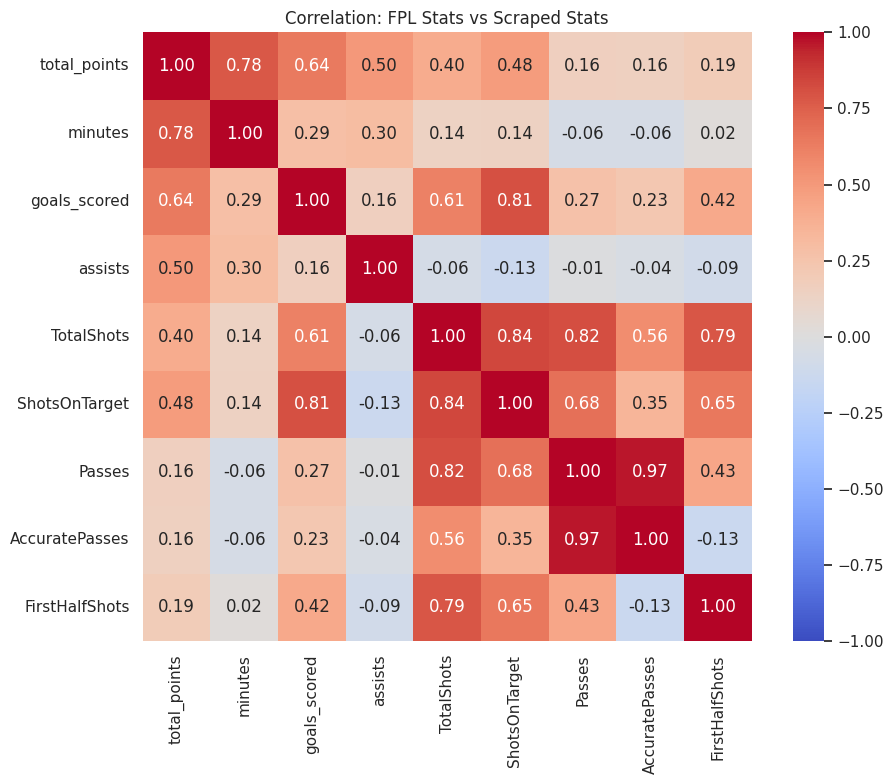

In [25]:
numeric_cols = [
    "total_points", "minutes", "goals_scored", "assists",
    "TotalShots", "ShotsOnTarget", "Passes", "AccuratePasses", "FirstHalfShots"
]
numeric_cols = [c for c in numeric_cols if c in df_stats.columns]

corr = df_stats[numeric_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(
    corr,
    annot=True,
    cmap="coolwarm",
    vmin=-1, vmax=1,
    fmt=".2f",
    square=True
)
plt.title("Correlation: FPL Stats vs Scraped Stats")
plt.tight_layout()
plt.show()


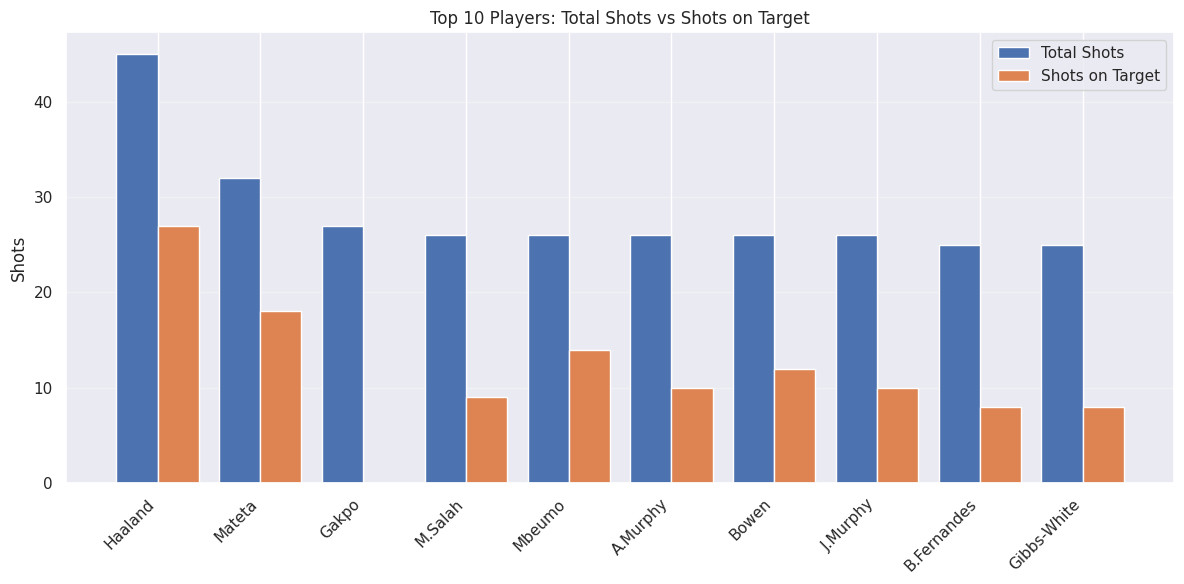

In [35]:
top10 = df_stats.sort_values("TotalShots", ascending=False).head(10)

plt.figure(figsize=(12, 6))
bar_width = 0.4
x = range(len(top10))

plt.bar(
    [p - bar_width/2 for p in x],
    top10["TotalShots"],
    width=bar_width,
    label="Total Shots"
)
plt.bar(
    [p + bar_width/2 for p in x],
    top10["ShotsOnTarget"],
    width=bar_width,
    label="Shots on Target"
)

plt.xticks(x, top10["web_name"], rotation=45, ha="right")
plt.ylabel("Shots")
plt.title("Top 10 Players: Total Shots vs Shots on Target")
plt.legend()
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

Haaland shoots the most while maintaining a good % of his shots on target compared to some players (like Salah)

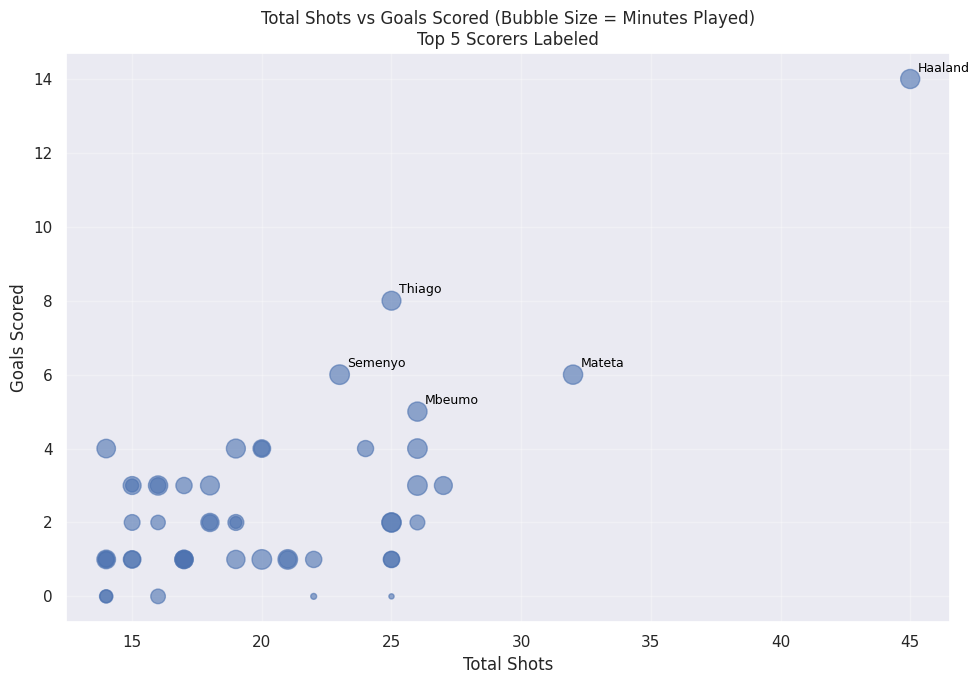

In [38]:
bubble = df_stats[["web_name", "TotalShots", "goals_scored", "minutes"]].dropna()

top5 = bubble.sort_values("goals_scored", ascending=False).head(5)

plt.figure(figsize=(10, 7))

plt.scatter(
    bubble["TotalShots"],
    bubble["goals_scored"],
    s=bubble["minutes"] / 5,
    alpha=0.6
)


for i, row in top5.iterrows():
    plt.text(
        row["TotalShots"] + 0.3,
        row["goals_scored"] + 0.2,
        row["web_name"],
        fontsize=9,
        color="black"
    )

plt.xlabel("Total Shots")
plt.ylabel("Goals Scored")
plt.title("Total Shots vs Goals Scored (Bubble Size = Minutes Played)\nTop 5 Scorers Labeled")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


Haaland is a clear outlier again because he's a robot and scores goals for fun

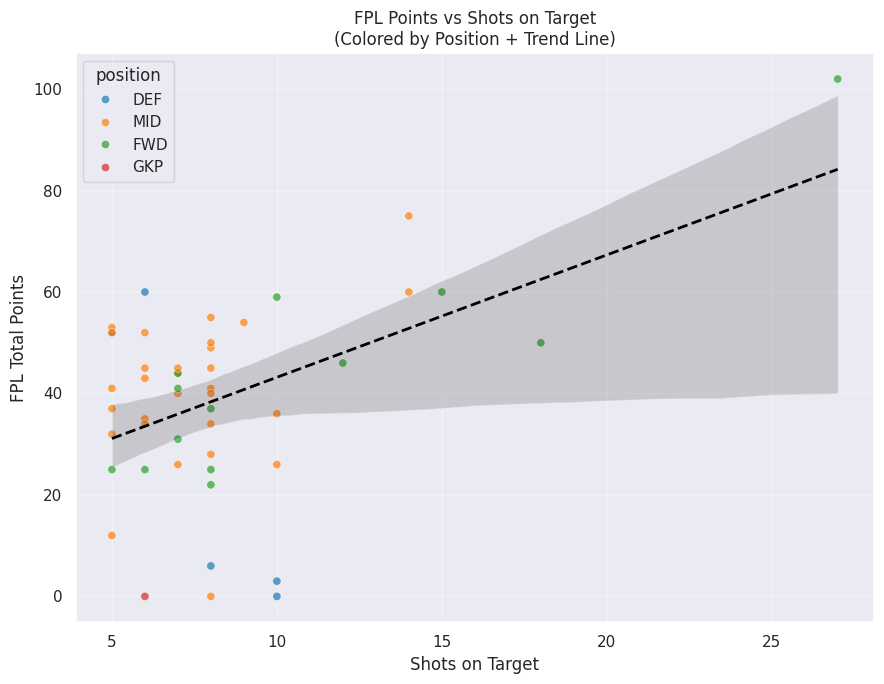

In [44]:
data = df_stats[["ShotsOnTarget", "total_points", "position"]].dropna()

plt.figure(figsize=(9,7))

sns.scatterplot(
    data=data,
    x="ShotsOnTarget",
    y="total_points",
    hue="position",
    palette="tab10",
    alpha=0.7
)

sns.regplot(
    data=data,
    x="ShotsOnTarget",
    y="total_points",
    scatter=False,
    color="black",
    line_kws={"linewidth": 2, "linestyle": "--"}
)

plt.xlabel("Shots on Target")
plt.ylabel("FPL Total Points")
plt.title("FPL Points vs Shots on Target\n(Colored by Position + Trend Line)")
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Players who have more shots on target, tend to get more FPL points

/tmp/ipython-input-1093049152.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


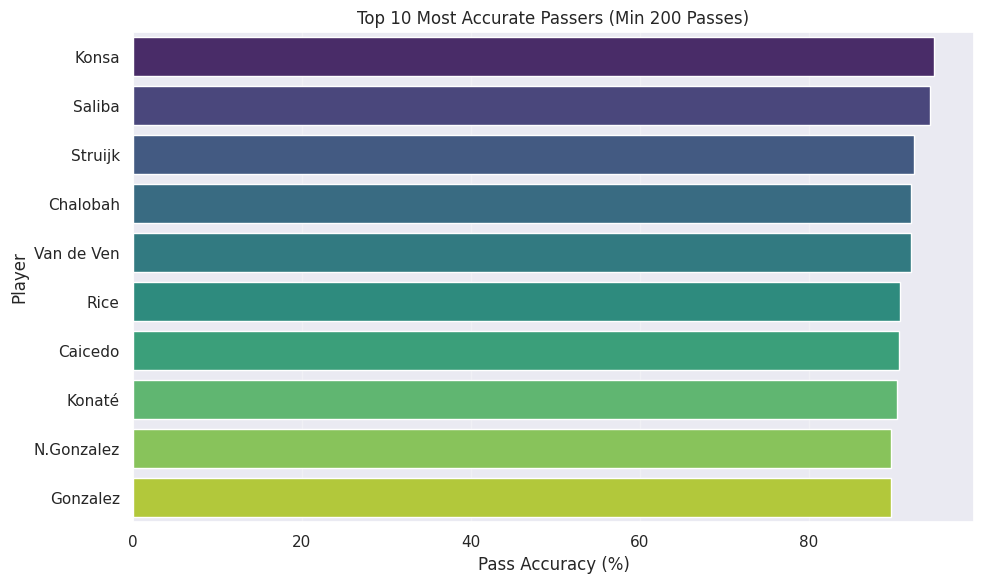

In [45]:
df_passacc = df_stats[["web_name", "Passes", "AccuratePasses"]].dropna()
df_passacc["PassAccuracy"] = df_passacc["AccuratePasses"] / df_passacc["Passes"] * 100

df_passacc = df_passacc[df_passacc["Passes"] > 200]

top10 = df_passacc.sort_values("PassAccuracy", ascending=False).head(10)

plt.figure(figsize=(10,6))
sns.barplot(
    data=top10,
    x="PassAccuracy",
    y="web_name",
    palette="viridis"
)

plt.xlabel("Pass Accuracy (%)")
plt.ylabel("Player")
plt.title("Top 10 Most Accurate Passers (Min 200 Passes)")
plt.grid(axis="x", alpha=0.3)
plt.tight_layout()
plt.show()


A chart without Haaland? Konsa has the best passing accuracy in the league, it looks like defenders and midfielders have the best passing accuracy in the league